### QML using Qiskit on sample dataset

Qiskit is IBM's package to create quantum circuits and execute them on a local simulator or that can also be sent to IBMQ, a real quantum computer. This code does not use IBMQ. 

In [1]:
import qiskit

In [2]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from qiskit.aqua.utils import split_dataset_to_data_and_labels 
from sklearn import svm
from matplotlib import pyplot as plt
from qiskit.ml.datasets import ad_hoc_data
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\nj\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Plot and observe original dataset

In [5]:
n = 2 # number of principal components kept
training_dataset_size = 20
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = ad_hoc_data(training_dataset_size, testing_dataset_size, n, gap=0.3)

data_train, _ = split_dataset_to_data_and_labels(training_input)
data_test, _ = split_dataset_to_data_and_labels(test_input)
#print(test_input, class_labels)

In [6]:
import qiskit as qk

# Creating Qubits
q = qk.QuantumRegister(2)
# Creating Classical Bits
c = qk.ClassicalRegister(2)

So far we only have an empty quantum circuit with 2 qubits (`q0_0` and `q0_1`) and 2 classical registers (`c0_0` and `c0_1`).

In [7]:
circuit = qk.QuantumCircuit(q, c)
print(circuit)

         
q0_0: |0>
         
q0_1: |0>
         
 c0_0: 0 
         
 c0_1: 0 
         


As an example we add a Hadamard gate (h) to the 0-th qubit and a Controlled-Not (also called Controlled-X, CNOT or CX) gate to the circuit, where the control qubit is qubit 0 and the target qubit is qubit 1.

In [8]:
# Initialize empty circuit
circuit = qk.QuantumCircuit(q, c)
# Hadamard Gate on the first Qubit
circuit.h(q[0])
# CNOT Gate on the first and second Qubits
circuit.cx(q[0], q[1])
# Measuring the Qubits
circuit.measure(q, c)
print (circuit)

         ┌───┐     ┌─┐   
q0_0: |0>┤ H ├──■──┤M├───
         └───┘┌─┴─┐└╥┘┌─┐
q0_1: |0>─────┤ X ├─╫─┤M├
              └───┘ ║ └╥┘
 c0_0: 0 ═══════════╩══╬═
                       ║ 
 c0_1: 0 ══════════════╩═
                         


In a next step we run this circuit on a quantum simulator. The measurements that we added before at the end of the circuit will measure if the single qubits are either in the state  |0⟩  or  |1⟩  by returning writing the classical bits 0 or 1 into the classical register.

In [9]:
# Using Qiskit Aer's Qasm Simulator: Define where do you want to run the simulation.
simulator = qk.BasicAer.get_backend('qasm_simulator')

# Simulating the circuit using the simulator to get the result
job = qk.execute(circuit, simulator, shots=100)
result = job.result()

# Getting the aggregated binary outcomes of the circuit.
counts = result.get_counts(circuit)
print (counts)

{'00': 51, '11': 49}


In [10]:
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

feature_map = SecondOrderExpansion(feature_dimension=2,depth=1)

In [11]:
x = np.array([0.6, 0.3])
print(feature_map.construct_circuit(x))

        ┌──────────┐┌──────────────┐┌──────────────┐┌──────────────┐
q_0: |0>┤ U2(0,pi) ├┤0             ├┤0             ├┤0             ├
        ├──────────┤│  Evolution^1 ││  Evolution^1 ││  Evolution^1 │
q_1: |0>┤ U2(0,pi) ├┤1             ├┤1             ├┤1             ├
        └──────────┘└──────────────┘└──────────────┘└──────────────┘


Qiskit aqua also provides a pre-defined function to train the whole QSVM. We only have to provide the feature map, a training and a test set and Qiskit will do all the work for us.

Apart from finding the quantum Kernel the QSVM algorithm does only classical optimization. In the end there is no difference to the classical SVM, except that the Kernels are coming from a quantum distribution.

QSVM will minimize the loss

In [12]:
from qiskit.aqua.algorithms import QSVM

qsvm = QSVM(feature_map, training_input, test_input)

Finally we define where to run this algorithm. This code is executed on a local QASM Simulator. But the algorithm could also be sent to the IBMQ an be evaluated on a real quantum computer.

We will have to define the shots, which are the number of measurements that we will take for each qubit. And for better reproducability we also set here the random seeds seed_simulator and see_transpiler.

In [13]:
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit import BasicAer
from qiskit.aqua.input import ClassificationInput

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)

result = qsvm.run(quantum_instance)
#alg_input = ClassificationInput(training_dataset=training_input, test_dataset=test_input, datapoints=None)
#result = run_algorithm(params, algo_input=alg_input, backend=backend)

`results` is a dictionary that contains elements like the kernel matrix, the label predictions and also the classical weights of the QSVM.

Since the training set contains 40 elements, the kernel matrix has dimension 40x40

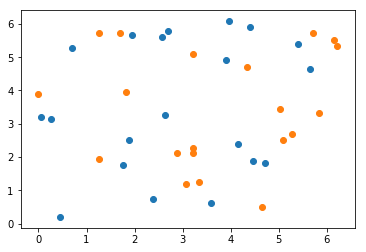

size training set: 40
Matrix dimension: (40, 40)


In [14]:
plt.scatter(training_input['B'][:,0], training_input['B'][:,1])
plt.scatter(training_input['A'][:,0], training_input['A'][:,1])
plt.show()
length_data = len(training_input['B']) + len(training_input['A'])
print("size training set: {}".format(length_data))
print("Matrix dimension: {}".format(result['kernel_matrix_training'].shape))

The success ratio shows how accurate the QSVM predicts the labels of Question dataset

In [20]:
print("testing accuracy: ", result['testing_accuracy'])
print("testing success ratio: ", result['test_success_ratio'])

testing accuracy:  0.95
testing success ratio:  0.95


In [16]:
test_set = np.concatenate((test_input['B'], test_input['A']))
y_test = qsvm.predict(test_set, quantum_instance)

The first result plot shows the label predictions of the QSVM and the second plot shows the test labels.

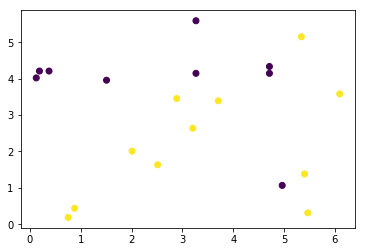

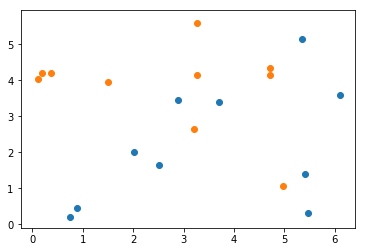

In [17]:
plt.scatter(test_set[:, 0], test_set[:,1], c=y_test)
plt.show()

plt.scatter(test_input['B'][:,0], test_input['B'][:,1])
plt.scatter(test_input['A'][:,0], test_input['A'][:,1])
plt.show()

We can repeat these above steps on any of the other datasets using load_iris(), load_digits() & load_wine() to observe how the results change